Building the Upstream using raw ACE and Wind Data and Comparing it to OMNI and Artemis and seeing if we are better than NASA.

Packages

In [1]:
# region <Importing Packages>
import datetime as dt

import pandas as pd
import pyspedas
#from pyqtgraph.graphicsItems.PlotDataItem import dataType
from pyspedas import tplot
import matplotlib.pyplot as plt
from pytplot import get_data
#import pandas as pd
import numpy as np
# endregion

01-Dec-25 14:35:09: C:\Users\Brian\anaconda3\envs\Research_Espen\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(



In [2]:
RE = 6371              # Earth radius in kmeters.
l1_dist = 1495980      # L1 distance in km.
kboltz = 1.380649E-23  # Boltzmann constant, J/K
mp = 1.67262192E-27    # Proton mass in Kg
bound_dist = 32 * RE   # Distance to BATS-R-US upstream boundary from Earth.

Importing Data (ACE, Wind, OMNI)

In [3]:

#This is where you input where to start and stop
start = "2016-05-06/12:00:00"
stop = "2016-05-07/11:59:59"

#This code allows us to shift the start a couple of hours back.
sec = 5400
date_start = pd.to_datetime(start)
shift = pd.Timedelta(sec, unit='s')
ts = date_start-shift
shifted_start = ts.strftime('%Y-%m-%d %H:%M:%S')


In [4]:
# region <Importing OMNI Data>
#This code allows us to get data from OMNI.

pyspedas.projects.omni.data(trange=[start, stop], datatype='1min', level='hro2', time_clip=True)
omni = pd.DataFrame({
    'Time': get_data('BZ_GSM')[0],
    'BY': get_data('BY_GSM')[1],
    'BZ': get_data('BZ_GSM')[1],
    'IMF': get_data('IMF')[1],
    "ts": get_data('Timeshift')[1],
    'VX': get_data('Vx')[1],
    'VY': get_data('Vy')[1],
    'VZ': get_data('Vz')[1],
    'Density': get_data('proton_density')[1],
    'Temp': get_data('T')[1],
    'X': get_data('x')[1],
})

#The data will then be interpolated to 1 minute intervals
omni['Time'] = pd.to_datetime(omni['Time'], unit='s')
omni = omni.set_index('Time')
omni = omni.resample('min').mean().interpolate(method='linear').ffill().bfill()
omni = omni.reset_index()
# endregion

01-Dec-25 14:35:11: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro2_1min/2016/
01-Dec-25 14:35:18: File is current: omni_data/hro2_1min/2016/omni_hro2_1min_20160501_v01.cdf


In [5]:
# region <Importing ACE Data>
#This code allows us to get data from ACE.

pyspedas.projects.ace.mfi(trange=[shifted_start, stop], datatype='h3', time_clip=True)
ace = pd.DataFrame({
    'Time': get_data('BGSM')[0],
    'BX': get_data('BGSM')[1][:,0],
    'BY': get_data('BGSM')[1][:,1],
    'BZ': get_data('BGSM')[1][:,2],

},columns = ['Time','BX','BY','BZ']).replace(to_replace=[-1.00000E+31], value=np.nan)


#The data will then be interpolated to 1 second intervals
ace['Time'] = pd.to_datetime(ace['Time'], unit='s')
ace = ace.set_index('Time')
ace = ace.resample('s').mean().interpolate(method='linear').ffill()
ace = ace.reset_index()
# endregion

01-Dec-25 14:35:22: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/ace/mag/level_2_cdaweb/mfi_h3/2016/
01-Dec-25 14:35:26: File is current: ace_data/mag/level_2_cdaweb/mfi_h3/2016/ac_h3_mfi_20160506_v02.cdf
01-Dec-25 14:35:29: File is current: ace_data/mag/level_2_cdaweb/mfi_h3/2016/ac_h3_mfi_20160507_v02.cdf


In [6]:
pyspedas.projects.ace.swe(trange=[shifted_start, stop],datatype='h0', time_clip=True)
ace2 = pd.DataFrame({
    'Time': get_data('V_GSE')[0],
    'VX': get_data('V_GSE')[1][:,0],
    'VY': get_data('V_GSE')[1][:,1],
    'VZ': get_data('V_GSE')[1][:,2],
    "NP": get_data('Np')[1],
    "Temp": get_data('Tpr')[1],

},columns = ['Time','VX','VY','VZ','NP','Temp']).replace(to_replace=[-1.00000E+31], value=np.nan)


#The data will then be interpolated to 1 second intervals
ace2['Time'] = pd.to_datetime(ace2['Time'], unit='s')
ace2 = ace2.set_index('Time')
ace2 = ace2.resample('s').mean().interpolate(method='linear').ffill()
ace2 = ace2.reset_index()

01-Dec-25 14:35:36: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/ace/swepam/level_2_cdaweb/swe_h0/2016/
01-Dec-25 14:35:43: File is current: ace_data/swepam/level_2_cdaweb/swe_h0/2016/ac_h0_swe_20160506_v11.cdf
01-Dec-25 14:35:47: File is current: ace_data/swepam/level_2_cdaweb/swe_h0/2016/ac_h0_swe_20160507_v11.cdf


In [7]:
# region <Importing WIND Data>
#This code allows us to get data from Wind.
pyspedas.projects.wind.mfi(trange=[shifted_start, stop], datatype='h0', time_clip=True)
wind = pd.DataFrame({
    'Time': get_data('B3GSM')[0],
    'BX': get_data('B3GSM')[1][:,0],
    'BY': get_data('B3GSM')[1][:,1],
    'BZ': get_data('B3GSM')[1][:,2],

}, columns = ['Time','BX','BY', 'BZ']).replace(to_replace=[-1.00000E+31], value=np.nan)


#The data will then be interpolated to 1 second intervals
wind['Time'] = pd.to_datetime(wind['Time'], unit='s')
wind = wind.set_index('Time')
wind = wind.resample('s').mean().interpolate(method='linear').ffill()
wind = wind.reset_index()
# endregion

01-Dec-25 14:35:48: File is current: wind_data/wind_masters/wi_h0_mfi_00000000_v01.cdf
01-Dec-25 14:35:48: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h0/2016/
01-Dec-25 14:35:52: File is current: wind_data/mfi/mfi_h0/2016/wi_h0_mfi_20160506_v05.cdf
01-Dec-25 14:35:56: File is current: wind_data/mfi/mfi_h0/2016/wi_h0_mfi_20160507_v05.cdf


In [8]:
pyspedas.projects.wind.swe(trange=[shifted_start,stop], datatype='h1', varnames=[], time_clip=True)
temp = (mp/(2*kboltz))*(get_data('Proton_W_moment')[1]*1000)**2
wind2 = pd.DataFrame({
    'Time': get_data('Proton_VX_moment')[0],
    'VX': get_data('Proton_VX_moment')[1],
    'VY': get_data('Proton_VY_moment')[1],
    'VZ': get_data('Proton_VZ_moment')[1],
    "NP": get_data('Proton_Np_moment')[1],
    'Temp':temp,

}, columns = ['Time','VX', 'VY','VZ','NP','Temp']).replace(to_replace=[-1.00000E+31], value=np.nan)

#The data will then be interpolated to 1 second intervals
wind2['Time'] = pd.to_datetime(wind2['Time'], unit='s')
wind2 = wind2.set_index('Time')
wind2 = wind2.resample('s').mean().interpolate(method='linear').ffill()
wind2 = wind2.reset_index()


01-Dec-25 14:35:59: File is current: wind_data/wind_masters/wi_h1_swe_00000000_v01.cdf
01-Dec-25 14:35:59: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/wind/swe/swe_h1/2016/
01-Dec-25 14:36:03: Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'RemoteDisconnected('Remote end closed connection without response')': /pub/data/wind/swe/swe_h1/2016/wi_h1_swe_20160506_v01.cdf
01-Dec-25 14:36:06: File is current: wind_data/swe/swe_h1/2016/wi_h1_swe_20160506_v01.cdf
01-Dec-25 14:36:10: File is current: wind_data/swe/swe_h1/2016/wi_h1_swe_20160507_v01.cdf


Getting Upstream data

use the same process, upstream mag file. in one arroy pull out bx by bz., make a new array with vx vy vz, etc. then rum the l1_spool and propagate them

In [9]:

up_time = []
shift = []

bx = []
by = []
bz = []


pt_ID = []
for i in range(len(omni['IMF'])):
    delta = pd.Timedelta(omni['ts'][i], unit='s')
    time = omni['Time'][i] - delta
    isotime = time.isoformat()+'.000Z'
    shift.append(delta)


    match omni['IMF'][i]:

        #If the spacecraft ID is 71, get the data from ace.
        case 71:
            ind = ace.loc[ace['Time'] == omni['Time'].iloc[i]-delta].index[0]
            #if ace doesn't have the data, get the data from wind

            if np.isnan(ace['BZ'][ind]):
                print("found a nan")
                ind = wind.loc[wind['Time'] == omni['Time'].iloc[i]-delta].index[0]
                print('1')
                bx.append(wind['BX'][ind])
                by.append(wind['BY'][ind])
                bz.append(wind['BZ'][ind])
                up_time.append(isotime)
                pt_ID.append(51)
            else:
                bx.append(ace['BX'][ind])
                by.append(ace['BY'][ind])
                bz.append(ace['BZ'][ind])
                up_time.append(isotime)
                pt_ID.append(71)


        #if the spacecraft ID is 51 or 52 get the data from wind
        case 51 | 52:

            ind = wind.loc[wind['Time'] == omni['Time'].iloc[i]-delta].index[0]
            #if wind doesn't have the data, get the data from ace
            if np.isnan(wind['BZ'][ind]):
                print("3")
                ind = ace.loc[ace['Time'] == omni['Time'].iloc[i]-delta].index[0]
                bx.append(ace['BX'][ind])
                by.append(ace['BY'][ind])
                bz.append(ace['BZ'][ind])

                up_time.append(isotime)
                pt_ID.append(71)

            else:
                print('4')
                bx.append(wind['BX'][ind])
                by.append(wind['BY'][ind])
                bz.append(wind['BZ'][ind])

                up_time.append(isotime)
                pt_ID.append(51)


        case _:

            id = pt_ID[-1]
            bx.append(np.nan)
            by.append(np.nan)
            bz.append(np.nan)

            up_time.append(isotime)
            pt_ID.append(id)


mfi = pd.DataFrame({'Time': up_time,'BX':bx,'BY':by, 'BZ':bz})
mfi = mfi.sort_values(by='Time')
mfi = mfi.set_index('Time')

mfi = mfi.reset_index()

#avg_ts = pd.to_timedelta(pd.Series(shift)).mean()
#print(avg_ts)


In [10]:

up_time = []
shift = []

vx = []
vy = []
vz = []

npr = []
temp = []

pt_ID = []
for i in range(len(omni['IMF'])):
    delta = pd.Timedelta(omni['ts'][i], unit='s')
    time = omni['Time'][i] - delta
    isotime = time.isoformat()+'.000Z'
    shift.append(delta)


    match omni['IMF'][i]:

        #If the spacecraft ID is 71, get the data from ace.
        case 71:
            ind = ace2.loc[ace2['Time'] == omni['Time'].iloc[i]-delta].index[0]
            #if ace doesn't have the data, get the data from wind
            if np.isnan(ace2['VX'][ind]):
                ind = wind2.loc[wind2['Time'] == omni['Time'].iloc[i]-delta].index[0]
                vx.append(wind2['VX'][ind])
                vy.append(wind2['VY'][ind])
                vz.append(wind2['VZ'][ind])

                npr.append(wind2['NP'][ind])
                temp.append(wind2['Temp'][ind])

                pt_ID.append(51)
                up_time.append(isotime)

            else:
                vx.append(ace2['VX'][ind])
                vy.append(ace2['VY'][ind])
                vz.append(ace2['VZ'][ind])

                npr.append(ace2['NP'][ind])
                temp.append(ace2['Temp'][ind])
                up_time.append(isotime)
                pt_ID.append(71)


        #if the spacecraft ID is 51 or 52 get the data from wind
        case 51 | 52:
            ind = wind2.loc[wind2['Time'] == omni['Time'].iloc[i]-delta].index[0]
            #if wind doesn't have the data, get the data from ace
            if np.isnan(wind2['VX'][ind]):
                ind = ace2.loc[ace2['Time'] == omni['Time'].iloc[i]-delta].index[0]
                vx.append(ace2['VX'][ind])
                vy.append(ace2['VY'][ind])
                vz.append(ace2['VZ'][ind])

                npr.append(ace2['NP'][ind])
                temp.append(ace2['Temp'][ind])
                up_time.append(isotime)
                pt_ID.append(71)
            else:
                vx.append(wind2['VX'][ind])
                vy.append(wind2['VY'][ind])
                vz.append(wind2['VZ'][ind])

                npr.append(wind2['NP'][ind])
                temp.append(wind2['Temp'][ind])
                up_time.append(isotime)
                pt_ID.append(51)


        case _:

            id = pt_ID[-1]
            vx.append(np.nan)
            vy.append(np.nan)
            vz.append(np.nan)

            npr.append(np.nan)
            temp.append(np.nan)
            up_time.append(isotime)
            pt_ID.append(id)


swe = pd.DataFrame({'Time': up_time,'VX':vx,'VY':vy,'VZ':vz, 'Temp':temp,'NP':npr})
swe = swe.sort_values(by='Time')
swe = swe.set_index('Time')

swe = swe.reset_index()

#avg_ts = pd.to_timedelta(pd.Series(shift)).mean()
#print(avg_ts)


Plotting Data

TypeError: unsupported operand type(s) for +: 'Timedelta' and 'str'

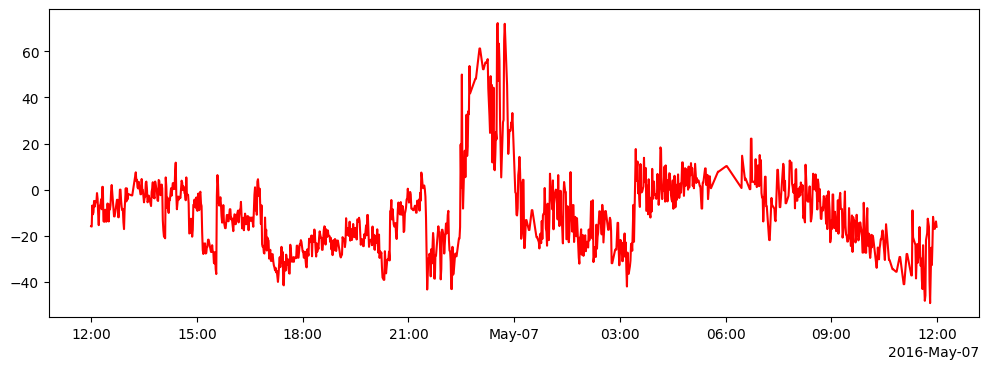

In [11]:
fig, ax = plt.subplots(figsize = (12,4))


#plt.plot(ace2['Time']+pd.Timedelta(minutes=59.5), ace2['BY'], label='Upstream', color='blue', linestyle='-')
plt.plot(omni['Time'], omni['VZ'], label='Omni', color='red', linestyle='-')
#plt.scatter(omni['Time'], omni['BZ'], c=omni['IMF'], cmap='viridis')
plt.plot(mfi['Time']+pd.Timedelta(minutes=59.5), swe['VZ'], label='Sorted', color='blue', linestyle='-')
#plt.scatter(upstream_wind['Time']+pd.Timedelta(minutes=59.5), upstream_wind['BZ'], c=upstream_wind['ID'], cmap='viridis')
#plt.plot(ace['Time']+pd.Timedelta(minutes=59.5), ace['BZ'], label='Ace', color='blue', linestyle='-')


plt.title('GSM Bz of Omni Data')
plt.xlabel('Date')
plt.ylabel('GSM Bz (nT)')

plt.legend()
#plt.colorbar()


#plt.xlim(dt.datetime.strptime("2016-05-06/22:00:00", "%Y-%m-%d/%H:%M:%S"), dt.datetime.strptime("2016-05-07/2:00:00", "%Y-%m-%d/%H:%M:%S"))

plt.show()

In [12]:
#fig, ax = plt.subplots(figsize = (12,12))

#plt.scatter(omni['VX'], upstream_wind['VX'], label='Upstream', color='blue')

#plt.xlabel('Omni Bz (nT)')
#plt.ylabel('Upstream Bz (nT)')
#plt.title('Graph of Upstream Bz VS Omni Bz')


#plt.legend()
#plt.show()


Uploading Data to the web

In [13]:
mfi.to_csv('mfi_data.csv', index=False)
swe.to_csv('swe_data.csv', index=False)

Right now the variables that work are BY, BZ, VX,VY,VZ, Omni doesnt have BX, NP. and I dont know if Temp is right